In [1]:
import deeplake
# ds = deeplake.load('hub://activeloop/wiki-art')

In [3]:
ds.visualize()

HINT: Please forward the port - 53259 to your local machine, if you are running on the cloud.


 * Serving Flask app 'dataset_visualizer'
 * Debug mode: off


In [12]:
dataloader_paintings = ds.pytorch(num_workers=0, batch_size=4, shuffle=False)

C:\Users\jacob\AppData\Roaming\Python\Python310\site-packages\deeplake\integrations\pytorch\common.py:137: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


In [3]:
from matplotlib import transforms


ds = deeplake.load("hub://activeloop/imagenet-train")
tform = transforms.Compose([
    transforms.ToPILImage(), # Must convert to PIL image for subsequent operations to run
    transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Lambda(lambda x: x.repeat(int(3/x.shape[0]), 1, 1)), # Some images are grayscale, so we need to add channels
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


dataloader = ds.pytorch(num_workers=0, batch_size=4, transform = {'images': tform, 'labels': None}, shuffle = True)
dataloader_other = ds.pytorch(num_workers=0, batch_size=4, shuffle=False)

NameError: name 'deeplake' is not defined

In [3]:
from datasets import load_dataset
from datasets import concatenate_datasets

ds = load_dataset("huggan/wikiart", split='train[0:6000]')

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

In [4]:
r_images_ds = load_dataset("random_images/dataset/train", split='train[0:6000]')

Resolving data files:   0%|          | 0/6469 [00:00<?, ?it/s]

In [5]:
len(ds)
ds = ds.rename_column("artist", "label")

In [6]:
# for i in range(len(ds)):
#     ds[i]['labels'] = 'painting'

ds[10]['label']

9

In [7]:
# for i in range(len(ds)):
#     ds[i]['labels'] = 'painting'

ds = ds.remove_columns("label").add_column("label", [0]*len(ds))
ds = ds.remove_columns('genre')
ds = ds.remove_columns('style')
ds[11]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1423x1382>,
 'label': 0}

In [8]:
r_images_ds = r_images_ds.add_column("label", [1]*len(ds))
r_images_ds[11]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=80x60>,
 'label': 1}

In [9]:
image_dataset = concatenate_datasets([r_images_ds, ds])

In [10]:
import cv2
import albumentations
import numpy as np

transform = albumentations.Compose([
    albumentations.RandomCrop(width=64, height=64),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.2),
])

In [11]:
def transforms(examples):
    examples["pixel_values"] = [
        transform(image=np.array(image))["image"] for image in examples["image"]
    ]

    return examples

In [12]:
image_dataset.set_transform(transforms)

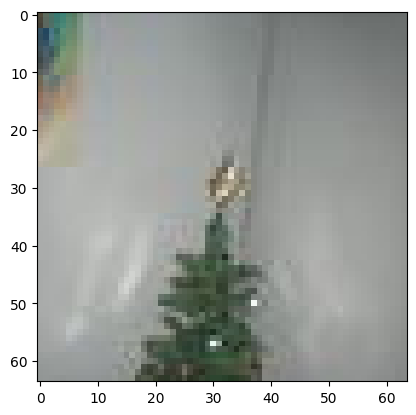

In [13]:
import numpy as np
import matplotlib.pyplot as plt

img = image_dataset[0]["pixel_values"]
plt.imshow(img)

In [14]:
from datasets import load_metric

metric = load_metric("accuracy", trust_remote_code=True)

C:\Users\jacob\AppData\Local\Temp\ipykernel_13504\272650354.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


In [15]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [16]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor 

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [28]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
            Grayscale,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [29]:
# split up training into training + validation
splits = image_dataset.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [30]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [31]:
labels = [0, 1]

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[1]

1

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.__version__)

True
2.3.1+cu118


In [2]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

def get_device_map() -> str:
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device_map()  # 'cpu'

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
    device_map='cpu',
)


NameError: name 'model_checkpoint' is not defined

In [52]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [53]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [54]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [55]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [56]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

  0%|          | 0/252 [00:00<?, ?it/s]

{'loss': 0.7346, 'grad_norm': 4.7906975746154785, 'learning_rate': 1.923076923076923e-05, 'epoch': 0.12}
{'loss': 0.2386, 'grad_norm': 1.2752577066421509, 'learning_rate': 3.846153846153846e-05, 'epoch': 0.24}
{'loss': 0.0087, 'grad_norm': 0.0010421701008453965, 'learning_rate': 4.911504424778761e-05, 'epoch': 0.36}
{'loss': 0.005, 'grad_norm': 12.082448959350586, 'learning_rate': 4.690265486725664e-05, 'epoch': 0.47}
{'loss': 0.0112, 'grad_norm': 0.014315508306026459, 'learning_rate': 4.469026548672566e-05, 'epoch': 0.59}
{'loss': 0.0092, 'grad_norm': 18.838348388671875, 'learning_rate': 4.247787610619469e-05, 'epoch': 0.71}
{'loss': 0.0231, 'grad_norm': 0.005520842038094997, 'learning_rate': 4.026548672566372e-05, 'epoch': 0.83}
{'loss': 0.0008, 'grad_norm': 0.0006030216463841498, 'learning_rate': 3.8053097345132744e-05, 'epoch': 0.95}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.004591928329318762, 'eval_accuracy': 0.9975, 'eval_runtime': 112.2718, 'eval_samples_per_second': 10.688, 'eval_steps_per_second': 0.338, 'epoch': 0.99}
{'loss': 0.0102, 'grad_norm': 0.0038931695744395256, 'learning_rate': 3.5840707964601774e-05, 'epoch': 1.07}
{'loss': 0.001, 'grad_norm': 0.0007370581733994186, 'learning_rate': 3.3628318584070804e-05, 'epoch': 1.18}


KeyboardInterrupt: 

In [57]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.006888017524033785, 'eval_accuracy': 0.9966666666666667, 'eval_runtime': 136.0728, 'eval_samples_per_second': 8.819, 'eval_steps_per_second': 0.279, 'epoch': 1.2}
***** eval metrics *****
  epoch                   =     1.1953
  eval_accuracy           =     0.9967
  eval_loss               =     0.0069
  eval_runtime            = 0:02:16.07
  eval_samples_per_second =      8.819
  eval_steps_per_second   =      0.279


In [58]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/JacobJan/swin-tiny-patch4-window7-224-finetuned-eurosat/commit/b51e215487c5a9156c38dad3924631efe4836ac4', commit_message='End of training', commit_description='', oid='b51e215487c5a9156c38dad3924631efe4836ac4', pr_url=None, pr_revision=None, pr_num=None)